# AOD and lightning correlations

## imports

In [1]:
import os
import awscli as aws
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date 
from datetime import time
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely import geometry

import matplotlib.pyplot as plt
import xarray 
import scipy.stats as ss 
import metpy  
import os
import h5py    
from pyhdf import SD
from mpl_toolkits.basemap import Basemap
import colormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import time
import calendar
from matplotlib.patches import Polygon
from netCDF4 import Dataset # Import the NetCDF Python interface
import netCDF4 as nc
import geopandas as gpd
from shapely.geometry import Point, Polygon
import bottleneck
import shapely
import dask
import nco
from sklearn.neighbors import NearestNeighbors
from math import radians, cos, sin, asin, sqrt
from textwrap import wrap
import matplotlib.patches as mpatches
import matplotlib.gridspec as grd
from matplotlib.ticker import LogFormatter 
import matplotlib.ticker as ticker


from pyproj import _proj
from pyproj.utils import _convertback, _copytobuffer
import pysplit
import cfgrib
from scipy.stats import pearsonr
import seaborn as sns
from scipy.stats import ttest_ind


## load in 

In [2]:
data_nosmoke_aod = pd.read_csv('/data2/edworak/data/nosmoke_lightning_bt_aod.csv')
data_smoke_aod = pd.read_csv('/data2/edworak/data/smoke_lightning_bt_aod.csv')

data_smoke_aod = pd.read_csv('/data2/edworak/data/smoke_lightning_bt_aod.csv')

hours29 = [8, 9, 10, 11]
# can't do hour 12 becasue no birghness temperature 
mins29 = range(0, 60, 10)

num_strikes_smoke_aod = np.zeros((len(hours29), len(mins29)))
mean_current_smoke_aod = np.zeros((len(hours29), len(mins29)))
mean_pos_current_smoke_aod = np.zeros((len(hours29), len(mins29)))
mean_neg_current_smoke_aod = np.zeros((len(hours29), len(mins29)))
percent_pos_current_smoke_aod = np.zeros((len(hours29), len(mins29)))
num_pos_current_smoke_aod =  np.zeros((len(hours29), len(mins29)))
num_neg_current_smoke_aod =  np.zeros((len(hours29), len(mins29)))
cloud_smoke_aod =  np.zeros((len(hours29), len(mins29)))
cloud_ground_smoke_aod =  np.zeros((len(hours29), len(mins29)))
pos_cloud_ground_smoke_aod =  np.zeros((len(hours29), len(mins29)))
neg_cloud_ground_smoke_aod =  np.zeros((len(hours29), len(mins29)))
pos_cloud_smoke_aod =  np.zeros((len(hours29), len(mins29)))
neg_cloud_smoke_aod =  np.zeros((len(hours29), len(mins29)))
percent_pos_current_cloud_ground_smoke_aod =  np.zeros((len(hours29), len(mins29)))
percent_pos_current_cloud_smoke_aod =  np.zeros((len(hours29), len(mins29)))

def smoke_function(data_smoke_aod):
        for i in range(len(hours29)): 
            for j in range(len(mins29)): 
                
                    time = data_smoke_aod.loc[(data_smoke_aod.CMI_C14 <= -50) & (data_smoke_aod.hour == hours29[i]) & (data_smoke_aod.minute >= mins29[j]) & (data_smoke_aod.minute <= mins29[j] + 9)]
                
                    
                    strikes_smoke_aod = (time.loc[(time["l_lon"] >= -122)& (time["l_lon"] <= -114) & 
                                                (time["l_lat"] >= 58) & (time["l_lat"] <= 60.5)])
                    

                    if len(strikes_smoke_aod) >= 1: 
                    
                        num_strikes_smoke_aod[i,j] = len(strikes_smoke_aod)
                        mean_current_smoke_aod[i,j] = np.mean(abs(strikes_smoke_aod["peak-current"]))

                        pos_current_smoke_aod = strikes_smoke_aod.loc[(strikes_smoke_aod["peak-current"] > 0)]
                        num_pos_current_smoke_aod[i,j]= len(pos_current_smoke_aod)
                        mean_pos_current_smoke_aod[i,j] = np.mean(pos_current_smoke_aod["peak-current"])

                        neg_current_smoke_aod = strikes_smoke_aod.loc[(strikes_smoke_aod["peak-current"] < 0)]
                        num_neg_current_smoke_aod[i,j] = len(neg_current_smoke_aod)
                        mean_neg_current_smoke_aod[i,j] = np.mean(neg_current_smoke_aod["peak-current"])
                        
                        cloud_count_smoke_aod = strikes_smoke_aod.loc[(strikes_smoke_aod["C or G"] == "C")]
                        cloud_smoke_aod[i,j] = len(cloud_count_smoke_aod)
                        pos_cloud_count_smoke_aod = cloud_count_smoke_aod.loc[(cloud_count_smoke_aod["peak-current"] > 0)]
                        pos_cloud_smoke_aod[i,j] = len(pos_cloud_count_smoke_aod)
                        neg_cloud_count_smoke_aod = cloud_count_smoke_aod.loc[(cloud_count_smoke_aod["peak-current"] < 0)]
                        neg_cloud_smoke_aod[i,j] = len(neg_cloud_count_smoke_aod)
                        
                        ground_count_smoke_aod = strikes_smoke_aod.loc[(strikes_smoke_aod["C or G"] == "G")]
                        cloud_ground_smoke_aod[i, j] = len(ground_count_smoke_aod)
                        pos_cloud_ground_count_smoke_aod = ground_count_smoke_aod.loc[(ground_count_smoke_aod["peak-current"] > 0)]
                        pos_cloud_ground_smoke_aod[i,j] = len(pos_cloud_ground_count_smoke_aod)
                        neg_cloud_ground_count_smoke_aod= ground_count_smoke_aod.loc[(ground_count_smoke_aod["peak-current"] < 0)]
                        neg_cloud_ground_smoke_aod[i,j] = len(neg_cloud_ground_count_smoke_aod)
                        
                        if len(strikes_smoke_aod) > 2: 
                            percent_pos_current_smoke_aod[i,j] = (len(pos_current_smoke_aod["peak-current"]) / len(strikes_smoke_aod)) * 100
                        
                        if len(cloud_count_smoke_aod) > 2:    
                            percent_pos_current_cloud_smoke_aod[i,j] = (len(pos_cloud_count_smoke_aod["peak-current"]) / len(cloud_count_smoke_aod)) * 100
                        
                        if len(ground_count_smoke_aod) > 2:  
                            percent_pos_current_cloud_ground_smoke_aod[i,j] = (len(pos_cloud_ground_count_smoke_aod["peak-current"]) / len(ground_count_smoke_aod)) * 100

        return(num_strikes_smoke_aod, percent_pos_current_smoke_aod, num_pos_current_smoke_aod, num_neg_current_smoke_aod, 
            mean_current_smoke_aod, mean_pos_current_smoke_aod, mean_neg_current_smoke_aod, cloud_smoke_aod, 
            cloud_ground_smoke_aod, pos_cloud_smoke_aod,  neg_cloud_smoke_aod, pos_cloud_ground_smoke_aod,  neg_cloud_ground_smoke_aod, 
             percent_pos_current_cloud_smoke_aod, percent_pos_current_cloud_ground_smoke_aod)


In [3]:
## merra 

m_clean1_aod = pd.read_csv("/data2/edworak/data/merra_lightning_AODANA_clean1.csv", sep = ",")
m_clean1_bc = pd.read_csv("/data2/edworak/data/merra_lightning_BCCMASS_clean1.csv", sep = ",")

m_clean2_aod = pd.read_csv("/data2/edworak/data/merra_lightning_AODANA_clean2.csv", sep = ",")
m_clean2_bc = pd.read_csv("/data2/edworak/data/merra_lightning_BCCMASS_clean2.csv", sep = ",")

m_clean3_aod = pd.read_csv("/data2/edworak/data/merra_lightning_AODANA_clean3.csv", sep = ",")
m_clean3_bc = pd.read_csv("/data2/edworak/data/merra_lightning_BCCMASS_clean3.csv", sep = ",")

m_clean4_aod = pd.read_csv("/data2/edworak/data/merra_lightning_AODANA_clean4.csv", sep = ",")
m_clean4_bc = pd.read_csv("/data2/edworak/data/merra_lightning_BCCMASS_clean4.csv", sep = ",")

m_clean5_aod = pd.read_csv('/data2/edworak/data/nosmoke_lightning_bt_aod.csv', sep = ",") 
m_clean5_bc = pd.read_csv('/data2/edworak/data/merra_nosmoke_lightning_bt_bc.csv', sep = ",") 

m_smoke_aod = pd.read_csv('/data2/edworak/data/smoke_lightning_bt_aod.csv', sep = ",") 
m_smoke_bc = pd.read_csv('/data2/edworak/data/merra_smoke_lightning_bt_bc.csv', sep = ",")

m_pyrocb_aod = pd.read_csv('/data2/edworak/data/merra_pyrocb_lightning_bt_aod.csv', sep = ",") 
m_pyrocb_bc = pd.read_csv('/data2/edworak/data/merra_pyrocb_lightning_bt_bc.csv', sep = ",") 


m_clean_aod = pd.concat([m_clean1_aod, m_clean2_aod, m_clean3_aod, m_clean4_aod, m_clean5_aod])
m_clean_bc = pd.concat([m_clean1_bc, m_clean2_bc, m_clean3_bc, m_clean4_bc, m_clean5_bc])

m_clean_aod = m_clean_aod.loc[(m_clean_aod.CMI_C14 < -50)]
m_clean_bc = m_clean_bc.loc[(m_clean_bc.CMI_C14 < -50)]
m_smoke_aod = m_smoke_aod.loc[(m_smoke_aod.CMI_C14 < -50)]
m_smoke_bc = m_smoke_bc.loc[(m_smoke_bc.CMI_C14 < -50)]
m_pyrocb_aod = m_pyrocb_aod.loc[(m_pyrocb_aod.CMI_C14 < -50)]
m_pyrocb_bc = m_pyrocb_bc.loc[(m_pyrocb_bc.CMI_C14 < -50)]

m_clean_aod = m_clean_aod[['year', 'month', 'day', 'hour', 'minute', 
       'lat', 'lon', 'peak current', 'C or G', 'CMI_C14', 'AODANA']]
m_clean_bc = m_clean_bc[['year', 'month', 'day', 'hour', 'minute', 
       'lat', 'lon', 'peak current', 'C or G', 'CMI_C14', 'BCCMASS']]
m_clean_bc

,year,month,day,hour,minute,lat,lon,peak current,C or G,CMI_C14,BCCMASS
0,2019,6,8,21,25,NaN,NaN,7.6,C,-53.667450,3.896522e-07
1,2019,6,8,21,25,NaN,NaN,9.5,C,-53.667450,3.896522e-07
2,2019,6,8,21,15,NaN,NaN,-8.1,C,-50.734770,4.199202e-07
3,2019,6,8,21,0,NaN,NaN,7.3,C,-51.752228,4.199202e-07
4,2019,6,8,21,20,NaN,NaN,-16.1,C,-52.051483,3.518172e-07
...,...,...,...,...,...,...,...,...,...,...,...
13832,2021,6,15,23,59,60.0,-116.250,NaN,G,-53.727295,5.810122e-07
13835,2021,6,15,23,59,59.5,-115.625,NaN,G,-57.019090,4.505106e-07
13836,2021,6,15,23,59,59.5,-115.000,NaN,C,-58.694916,4.807786e-07
13837,2021,6,15,23,59,59.5,-115.000,NaN,C,-60.251038,4.807786e-07


In [4]:
## cams 

c_clean1_aod = pd.read_csv('/data2/edworak/data/cams_lightning_aod550_clean1.csv', sep = ",")
c_clean1_bc = pd.read_csv('/data2/edworak/data/cams_lightning_bcaod550_clean1.csv', sep = ",")

c_clean2_aod = pd.read_csv('/data2/edworak/data/cams_lightning_aod550_clean2.csv', sep = ",")
c_clean2_bc = pd.read_csv('/data2/edworak/data/cams_lightning_bcaod550_clean2.csv', sep = ",")

c_clean3_aod = pd.read_csv('/data2/edworak/data/cams_lightning_aod550_clean3.csv', sep = ",")
c_clean3_bc = pd.read_csv('/data2/edworak/data/cams_lightning_bcaod550_clean3.csv', sep = ",")

c_clean4_aod = pd.read_csv('/data2/edworak/data/cams_lightning_aod550_clean4.csv', sep = ",")
c_clean4_bc = pd.read_csv('/data2/edworak/data/cams_lightning_bcaod550_clean4.csv', sep = ",")

c_clean5_aod = pd.read_csv('/data2/edworak/data/cams_nosmoke_lightning_bt_aod.csv', sep = ",") # delim_whitespace = True, 
c_clean5_bc = pd.read_csv('/data2/edworak/data/cams_nosmoke_lightning_bt_bc.csv', sep = ",") # delim_whitespace = True, 

c_clean_aod = pd.concat([c_clean1_aod, c_clean2_aod, c_clean3_aod, c_clean4_aod, c_clean5_aod])
c_clean_bc = pd.concat([c_clean1_bc, c_clean2_bc, c_clean3_bc, c_clean4_bc, c_clean5_bc])

c_smoke_aod = pd.read_csv('/data2/edworak/data/cams_smoke_lightning_bt_aod.csv', sep = ",") # delim_whitespace = True, 
c_smoke_bc = pd.read_csv('/data2/edworak/data/cams_smoke_lightning_bt_bc.csv', sep = ",") # delim_whitespace = True, 
c_pyrocb_aod = pd.read_csv('/data2/edworak/data/cams_pyrocb_lightning_bt_aod.csv', sep = ",") # delim_whitespace = True, 
c_pyrocb_bc = pd.read_csv('/data2/edworak/data/cams_pyrocb_lightning_bt_bc.csv', sep = ",") # delim_whitespace = True, 

c_clean_aod = c_clean_aod.loc[(c_clean_aod.CMI_C14 < -50)]
c_clean_bc = c_clean_bc.loc[(c_clean_bc.CMI_C14 < -50)]
c_smoke_aod = c_smoke_aod.loc[(c_smoke_aod.CMI_C14 < -50)]
c_smoke_bc = c_smoke_bc.loc[(c_smoke_bc.CMI_C14 < -50)]
c_pyrocb_aod = c_pyrocb_aod.loc[(c_pyrocb_aod.CMI_C14 < -50)]
c_pyrocb_bc = c_pyrocb_bc.loc[(c_pyrocb_bc.CMI_C14 < -50)]

c_clean_aod = c_clean_aod[['year', 'month', 'day', 'hour', 'minute', 
       'lat', 'lon', 'peak current', 'C or G', 'CMI_C14', 'aod550']]
c_clean_bc = c_clean_bc[['year', 'month', 'day', 'hour', 'minute', 
       'lat', 'lon', 'peak current', 'C or G', 'CMI_C14', 'bcaod550']]
c_clean_bc

,year,month,day,hour,minute,lat,lon,peak current,C or G,CMI_C14,bcaod550
0,2019,6,8,21,15,53.0877,-115.4588,-8.1,C,-50.734770,0.016091
1,2019,6,8,21,0,53.1334,-115.6042,7.3,C,-51.752228,0.016091
2,2019,6,8,21,0,53.1411,-115.6600,4.3,C,-51.931778,0.016091
3,2019,6,8,21,10,53.1362,-115.5337,18.7,C,-51.871918,0.016091
4,2019,6,8,21,55,53.3032,-117.3331,5.2,C,-53.128784,0.012527
...,...,...,...,...,...,...,...,...,...,...,...
18294,2021,6,15,23,59,NaN,NaN,NaN,G,-53.727295,0.012981
18297,2021,6,15,23,59,NaN,NaN,NaN,G,-57.019090,0.011437
18298,2021,6,15,23,59,NaN,NaN,NaN,C,-58.694916,0.011437
18299,2021,6,15,23,59,NaN,NaN,NaN,C,-60.251038,0.011437


## merra cams BC 

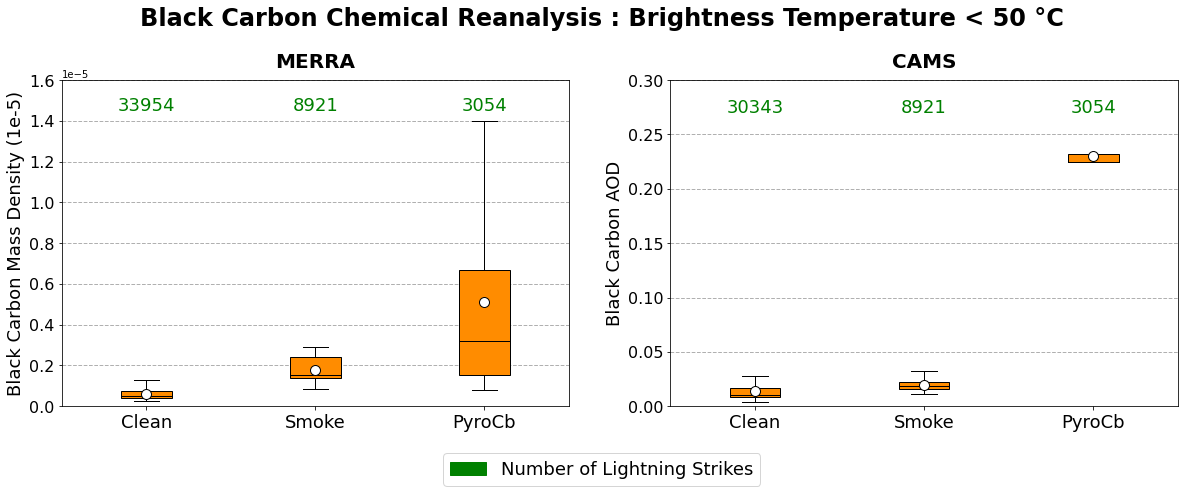

In [5]:
fig = plt.figure(figsize=(20,6))
gs = grd.GridSpec(1, 2, width_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])

degree_sign = u'\N{DEGREE SIGN}'
plt.suptitle("Black Carbon Chemical Reanalysis : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 24, y = 1.05) 

ax0.set_title("MERRA", fontsize = 20, fontweight='bold', y = 1.02) 
plt.yticks(fontsize = 16)
plt.ylim(0, 1.6e-5, 1e-7)

data =  [m_clean_bc.BCCMASS, m_smoke_bc.BCCMASS, m_pyrocb_bc.BCCMASS] 
box = ax0.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2]) # 

ax0.set_ylabel("Black Carbon Mass Density (1e-5)", color="black",fontsize=18)

plt.annotate("{:.0f}".format(len(m_clean_bc.BCCMASS)), xy =(0, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(m_smoke_bc.BCCMASS)), xy =(1, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_pyrocb_bc.BCCMASS)), xy =(2, 1.45e-5), fontsize = 18, color = "green", ha='center')

color1 = ['darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box['boxes'], color1):
    patch.set_facecolor(color)

labels = ["Clean", "Smoke", "PyroCb"]  
ax0.set_xticklabels(labels, fontsize = 18)

plt.gca().yaxis.grid(True, linestyle='--', linewidth=1)

# --------------------------------------------------


ax1 = plt.subplot(gs[1])

ax1.set_title("CAMS", fontweight='bold', fontsize = 20, y = 1.02) 

plt.yticks(fontsize = 16)
plt.ylim(0, 0.3, 0.01)
plt.yticks(fontsize = 16)

data =  [c_clean_bc.bcaod550, c_smoke_bc.bcaod550, c_pyrocb_bc.bcaod550] 
box = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2]) # 

ax1.set_ylabel("Black Carbon AOD", fontsize=18)

plt.annotate("{:.0f}".format(len(c_clean_bc.bcaod550)), xy =(0, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_smoke_bc.bcaod550)), xy =(1, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_pyrocb_bc.bcaod550)), xy =(2, 0.27), fontsize = 18, color = "green", ha='center')

color2 = ['darkorange', 'darkorange', 'darkorange']
for patch, color in zip(box['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Clean", "Smoke", "PyroCb"]  
ax1.set_xticklabels(labels, fontsize = 18)

green_patch = mpatches.Patch(color='green', label='Number of Lightning Strikes')
fig.legend(handles=[green_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.08), ncol=1, fancybox=True, shadow=False)

plt.gca().yaxis.grid(True, linestyle='--', linewidth=1)
plt.savefig("cams_merra_bc_subplots_allclean.png",bbox_inches = "tight", dpi = 800)
plt.show()



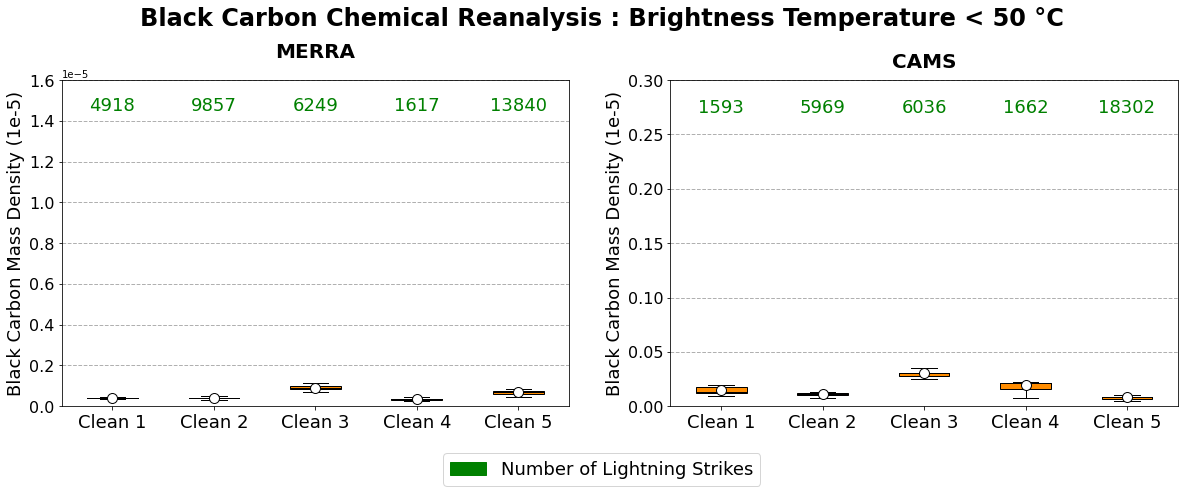

In [6]:
fig = plt.figure(figsize=(20,6))
gs = grd.GridSpec(1, 2, width_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])

degree_sign = u'\N{DEGREE SIGN}'
plt.suptitle("Black Carbon Chemical Reanalysis : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 24, y = 1.05) 

ax0.set_title("MERRA",  fontweight='bold', fontsize = 20, y = 1.05) 
plt.yticks(fontsize = 16)
plt.ylim(0, 1.6e-5, 1e-7)

data = [m_clean1_bc.BCCMASS, m_clean2_bc.BCCMASS, m_clean3_bc.BCCMASS, m_clean4_bc.BCCMASS, m_clean5_bc.BCCMASS] 
box = ax0.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2, 3, 4]) # 

ax0.set_ylabel("Black Carbon Mass Density (1e-5)", fontsize=18)

plt.annotate("{:.0f}".format(len(m_clean1_bc.BCCMASS)), xy =(0, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(m_clean2_bc.BCCMASS)), xy =(1, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean3_bc.BCCMASS)), xy =(2, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean4_bc.BCCMASS)), xy =(3, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean5_bc.BCCMASS)), xy =(4, 1.45e-5), fontsize = 18, color = "green", ha='center')


color1 = ['darkorange', 'darkorange', 'darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box['boxes'], color1):
    patch.set_facecolor(color)

labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]  
ax0.set_xticklabels(labels, fontsize = 18)
plt.gca().yaxis.grid(True, linestyle='--', linewidth=1)


# --------------------------------------------------

ax1 = plt.subplot(gs[1])

ax1.set_title("CAMS",  fontweight='bold', fontsize = 20, y = 1.02) 
plt.yticks(fontsize = 16)
plt.ylim(0, 0.3, 0.01)

data =  [c_clean1_bc.bcaod550, c_clean2_bc.bcaod550, c_clean3_bc.bcaod550, c_clean4_bc.bcaod550, c_clean5_bc.bcaod550] 
box = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2, 3, 4]) # 

ax1.set_ylabel("Black Carbon Mass Density (1e-5)", fontsize=18)

plt.annotate("{:.0f}".format(len(c_clean1_bc.bcaod550)), xy =(0, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_clean2_bc.bcaod550)), xy =(1, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean3_bc.bcaod550)), xy =(2, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean4_bc.bcaod550)), xy =(3, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean5_bc.bcaod550)), xy =(4, 0.27), fontsize = 18, color = "green", ha='center')

color1 = ['darkorange', 'darkorange', 'darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box['boxes'], color1):
    patch.set_facecolor(color)

labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]  
ax1.set_xticklabels(labels, fontsize = 18)

green_patch = mpatches.Patch(color='green', label='Number of Lightning Strikes')
fig.legend(handles=[green_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.08), ncol=1, fancybox=True, shadow=False)


plt.gca().yaxis.grid(True, linestyle='--', linewidth=1)
plt.savefig("cams_merra_bc_subplots_seperate_clean.png",bbox_inches = "tight", dpi = 800)
plt.show()



## lightning

## load in pyrocb data

In [7]:
correct_pyrocb = pd.read_csv("/data2/edworak/data/plxcorrected_bt_lightning_23_3.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_pyrocb = correct_pyrocb.sort_values('distance(km)', ascending=True)
correct_pyrocb = correct_pyrocb.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity'], keep='first') 
correct_pyrocb = correct_pyrocb.sort_index()

correct_pyrocb

,year,month,day,hour,minute,lat,lon,peak-current,C or G,polarity,CMI_C14,tlat,tlon,distance(km)
10,2021,6,30,23,0,51.369,-120.967,5.7,C,+,-51.692383,51.360366,-120.972499,0.786
17,2021,6,30,23,0,51.445,-120.868,-2.7,C,-,-50.674910,51.439617,-120.879446,1.309
30,2021,6,30,23,0,51.363,-120.958,10.6,C,+,-51.692383,51.360366,-120.972499,1.619
41,2021,6,30,23,0,51.360,-120.975,7.7,C,+,-51.692383,51.360366,-120.972499,0.279
56,2021,6,30,23,0,51.407,-121.011,7.4,C,+,-52.051483,51.395965,-121.023674,1.545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268834,2021,7,1,3,57,52.497,-120.656,-14.0,G,-,-54.924316,52.506990,-120.667335,1.382
268855,2021,7,1,3,55,52.481,-120.703,-26.5,G,-,-55.163727,52.467645,-120.684300,2.213
268881,2021,7,1,3,55,51.262,-120.877,2.3,C,+,-50.974167,51.254785,-120.888991,1.395
268907,2021,7,1,3,56,52.525,-120.721,2.3,C,+,-55.343260,52.544278,-120.718890,1.120


In [8]:
# correct_pyrocb = pd.read_csv("/data2/edworak/data/pyrocb_lightning_bt.csv", sep='\t')

hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 20)

num_strikes_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_current_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_pos_current_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_neg_current_pyrocb = np.zeros((len(hours1), len(mins1)))
percent_pos_current_pyrocb = np.zeros((len(hours1), len(mins1)))
num_pos_current_pyrocb =  np.zeros((len(hours1), len(mins1)))
num_neg_current_pyrocb =  np.zeros((len(hours1), len(mins1)))
cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
pos_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
neg_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))

def pyrocb_function(correct_pyrocb):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = correct_pyrocb.loc[(correct_pyrocb.CMI_C14 <= -50) & (correct_pyrocb.hour == hours1[i]) & (correct_pyrocb.minute >= mins1[j]) & (correct_pyrocb.minute <= mins1[j] + 19)]
                
                    
                    strikes_pyrocb = (time.loc[(time["lon"] >= -121.5)& (time["lon"] <= -119) & 
                                                (time["lat"] >= 51) & (time["lat"] <= 53)])
                    

                    if len(strikes_pyrocb) >= 1: 
                    
                        num_strikes_pyrocb[i,j] = len(strikes_pyrocb)
                        mean_current_pyrocb[i,j] = np.mean(abs(strikes_pyrocb["peak-current"]))

                        pos_current_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["peak-current"] > 0)]
                        num_pos_current_pyrocb[i,j]= len(pos_current_pyrocb)
                        mean_pos_current_pyrocb[i,j] = np.mean(pos_current_pyrocb["peak-current"])

                        neg_current_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["peak-current"] < 0)]
                        num_neg_current_pyrocb[i,j] = len(neg_current_pyrocb)
                        mean_neg_current_pyrocb[i,j] = np.mean(neg_current_pyrocb["peak-current"])
                        
                        cloud_count_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["C or G"] == "C")]
                        cloud_pyrocb[i,j] = len(cloud_count_pyrocb)
                        pos_cloud_count_pyrocb = cloud_count_pyrocb.loc[(cloud_count_pyrocb["peak-current"] > 0)]
                        pos_cloud_pyrocb[i,j] = len(pos_cloud_count_pyrocb)
                        neg_cloud_count_pyrocb = cloud_count_pyrocb.loc[(cloud_count_pyrocb["peak-current"] < 0)]
                        neg_cloud_pyrocb[i,j] = len(neg_cloud_count_pyrocb)
                        
                        ground_count_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["C or G"] == "G")]
                        cloud_ground_pyrocb[i, j] = len(ground_count_pyrocb)
                        pos_cloud_ground_count_pyrocb = ground_count_pyrocb.loc[(ground_count_pyrocb["peak-current"] > 0)]
                        pos_cloud_ground_pyrocb[i,j] = len(pos_cloud_ground_count_pyrocb)
                        neg_cloud_ground_count_pyrocb= ground_count_pyrocb.loc[(ground_count_pyrocb["peak-current"] < 0)]
                        neg_cloud_ground_pyrocb[i,j] = len(neg_cloud_ground_count_pyrocb)
                        
                        if len(strikes_pyrocb) > 2: 
                            percent_pos_current_pyrocb[i,j] = (len(pos_current_pyrocb["peak-current"]) / len(strikes_pyrocb)) * 100
                        
                        if len(cloud_count_pyrocb) > 2:    
                            percent_pos_current_cloud_pyrocb[i,j] = (len(pos_cloud_count_pyrocb["peak-current"]) / len(cloud_count_pyrocb)) * 100
                            percent_cloud_pyrocb[i,j] = (len(cloud_count_pyrocb["peak-current"]) / len(strikes_pyrocb)) * 100

                        if len(ground_count_pyrocb) > 2:  
                            percent_pos_current_cloud_ground_pyrocb[i,j] = (len(pos_cloud_ground_count_pyrocb["peak-current"]) / len(ground_count_pyrocb)) * 100

        return(num_strikes_pyrocb, percent_pos_current_pyrocb, num_pos_current_pyrocb, num_neg_current_pyrocb, 
            mean_current_pyrocb, mean_pos_current_pyrocb, mean_neg_current_pyrocb, cloud_pyrocb, 
            cloud_ground_pyrocb, pos_cloud_pyrocb,  neg_cloud_pyrocb, pos_cloud_ground_pyrocb,  neg_cloud_ground_pyrocb, 
             percent_pos_current_cloud_pyrocb, percent_pos_current_cloud_ground_pyrocb, percent_cloud_pyrocb)


In [9]:
d1 = {}

names1 = ["num_strikes_pyrocb", "percent_pos_current_pyrocb", "num_pos_current_pyrocb", "num_neg_current_pyrocb", 
           "mean_current_pyrocb", "mean_pos_current_pyrocb", "mean_neg_current_pyrocb", "cloud_pyrocb",
         "cloud_ground_pyrocb", "pos_cloud_pyrocb",  "neg_cloud_pyrocb", "pos_cloud_ground_pyrocb",  "neg_cloud_ground_pyrocb", 
        "percent_pos_current_cloud_pyrocb", "percent_pos_current_cloud_ground_pyrocb", "percent_cloud_pyrocb"]


for i in range(0, len(names1)):
    a1 = pyrocb_function(correct_pyrocb)[i]
    b1 = [item for sublist in a1 for item in sublist]
    d1[names1[i]] = b1

In [10]:
hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 20)

pyrocb_cloud_array = []
pyrocb_ground_array = []
pyrocb_cccg_array = []
pyrocb_neg_cloud_array = []
pyrocb_pos_cloud_array = []
pyrocb_neg_ground_array = []
pyrocb_pos_ground_array = []
pyrocb_percent_pos_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = correct_pyrocb.loc[(correct_pyrocb.CMI_C14 <= -50) & (correct_pyrocb.hour == hours1[i]) & (correct_pyrocb.minute >= mins1[j]) & (correct_pyrocb.minute <= mins1[j] + 19)]
                
                    
        strikes_pyrocb = (time.loc[(time["lon"] >= -121.5)& (time["lon"] <= -119) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 53)])
        
        if len(strikes_pyrocb) >= 1: 
            pyrocb_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            pyrocb_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))
            
            if len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]) >= 1:
                pyrocb_cccg_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]) / len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")])))

            pyrocb_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            pyrocb_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            
            pyrocb_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
            pyrocb_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

            #pyrocb_percent_pos_array.append(np.array(pyrocb_pos_ground_array / pyrocb_ground_array))
            
pyrocb_cloud_flat = [item for sublist in pyrocb_cloud_array for item in sublist]
pyrocb_ground_flat = [item for sublist in pyrocb_ground_array for item in sublist]
pyrocb_neg_cloud_flat = [item for sublist in pyrocb_neg_cloud_array for item in sublist]
pyrocb_pos_cloud_flat = [item for sublist in pyrocb_pos_cloud_array for item in sublist]
pyrocb_neg_ground_flat = [item for sublist in pyrocb_neg_ground_array for item in sublist]
pyrocb_pos_ground_flat = [item for sublist in pyrocb_pos_ground_array for item in sublist]


## load in smoke data

In [11]:
correct_smoke = pd.read_csv("/data2/edworak/data/smoke_plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_smoke = correct_smoke.sort_values('distance(km)', ascending=True)
correct_smoke = correct_smoke.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity', "CMI_C14"], keep='first') 
#correct_smoke = correct_smoke.drop_duplicates(keep='first') 

correct_smoke = correct_smoke.sort_index()


In [12]:
# correct_smoke = pd.read_csv("/data2/edworak/data/smoke_lightning_bt.csv", sep='\t')

hours1 = [8, 9, 10, 11]
mins1 = range(0, 60, 20)

num_strikes_smoke = np.zeros((len(hours1), len(mins1)))
mean_current_smoke = np.zeros((len(hours1), len(mins1)))
mean_pos_current_smoke = np.zeros((len(hours1), len(mins1)))
mean_neg_current_smoke = np.zeros((len(hours1), len(mins1)))
percent_pos_current_smoke = np.zeros((len(hours1), len(mins1)))
num_pos_current_smoke =  np.zeros((len(hours1), len(mins1)))
num_neg_current_smoke =  np.zeros((len(hours1), len(mins1)))
cloud_smoke =  np.zeros((len(hours1), len(mins1)))
cloud_ground_smoke =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_smoke =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_smoke =  np.zeros((len(hours1), len(mins1)))
pos_cloud_smoke =  np.zeros((len(hours1), len(mins1)))
neg_cloud_smoke =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_smoke =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_smoke =  np.zeros((len(hours1), len(mins1)))
percent_cloud_smoke =  np.zeros((len(hours1), len(mins1)))

def smoke_function(correct_smoke):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = correct_smoke.loc[(correct_smoke.CMI_C14 <= -50) & (correct_smoke.hour == hours1[i]) & (correct_smoke.minute >= mins1[j]) & (correct_smoke.minute <= mins1[j] + 19)]
                
                    
                    strikes_smoke = (time.loc[(time["lon"] >= -120)& (time["lon"] <= -114) & 
                                                (time["lat"] >= 58) & (time["lat"] <= 60.5)])
                    

                    if len(strikes_smoke) >= 1: 
                    
                        num_strikes_smoke[i,j] = len(strikes_smoke)
                        mean_current_smoke[i,j] = np.mean(abs(strikes_smoke["peak-current"]))

                        pos_current_smoke = strikes_smoke.loc[(strikes_smoke["peak-current"] > 0)]
                        num_pos_current_smoke[i,j]= len(pos_current_smoke)
                        mean_pos_current_smoke[i,j] = np.mean(pos_current_smoke["peak-current"])

                        neg_current_smoke = strikes_smoke.loc[(strikes_smoke["peak-current"] < 0)]
                        num_neg_current_smoke[i,j] = len(neg_current_smoke)
                        mean_neg_current_smoke[i,j] = np.mean(neg_current_smoke["peak-current"])
                        
                        cloud_count_smoke = strikes_smoke.loc[(strikes_smoke["C or G"] == "C")]
                        cloud_smoke[i,j] = len(cloud_count_smoke)
                        pos_cloud_count_smoke = cloud_count_smoke.loc[(cloud_count_smoke["peak-current"] > 0)]
                        pos_cloud_smoke[i,j] = len(pos_cloud_count_smoke)
                        neg_cloud_count_smoke = cloud_count_smoke.loc[(cloud_count_smoke["peak-current"] < 0)]
                        neg_cloud_smoke[i,j] = len(neg_cloud_count_smoke)
                        
                        ground_count_smoke = strikes_smoke.loc[(strikes_smoke["C or G"] == "G")]
                        cloud_ground_smoke[i, j] = len(ground_count_smoke)
                        pos_cloud_ground_count_smoke = ground_count_smoke.loc[(ground_count_smoke["peak-current"] > 0)]
                        pos_cloud_ground_smoke[i,j] = len(pos_cloud_ground_count_smoke)
                        neg_cloud_ground_count_smoke= ground_count_smoke.loc[(ground_count_smoke["peak-current"] < 0)]
                        neg_cloud_ground_smoke[i,j] = len(neg_cloud_ground_count_smoke)
                        
                        if len(strikes_smoke) > 2: 
                            percent_pos_current_smoke[i,j] = (len(pos_current_smoke["peak-current"]) / len(strikes_smoke)) * 100
                        
                        if len(cloud_count_smoke) > 2:    
                            percent_pos_current_cloud_smoke[i,j] = (len(pos_cloud_count_smoke["peak-current"]) / len(cloud_count_smoke)) * 100
                            percent_cloud_smoke[i,j] = (len(cloud_count_smoke["peak-current"]) / len(strikes_smoke)) * 100

                        if len(ground_count_smoke) > 2:  
                            percent_pos_current_cloud_ground_smoke[i,j] = (len(pos_cloud_ground_count_smoke["peak-current"]) / len(ground_count_smoke)) * 100

        return(num_strikes_smoke, percent_pos_current_smoke, num_pos_current_smoke, num_neg_current_smoke, 
            mean_current_smoke, mean_pos_current_smoke, mean_neg_current_smoke, cloud_smoke, 
            cloud_ground_smoke, pos_cloud_smoke,  neg_cloud_smoke, pos_cloud_ground_smoke,  neg_cloud_ground_smoke, 
             percent_pos_current_cloud_smoke, percent_pos_current_cloud_ground_smoke, percent_cloud_smoke)


In [13]:
d2 = {}

names2 = ["num_strikes_smoke", "percent_pos_current_smoke", "num_pos_current_smoke", "num_neg_current_smoke", 
           "mean_current_smoke", "mean_pos_current_smoke", "mean_neg_current_smoke", "cloud_smoke",
         "cloud_ground_smoke", "pos_cloud_smoke",  "neg_cloud_smoke", "pos_cloud_ground_smoke",  "neg_cloud_ground_smoke", 
        "percent_pos_current_cloud_smoke", "percent_pos_current_cloud_ground_smoke", "percent_cloud_smoke"]


for i in range(0, len(names1)):
    a2 = smoke_function(correct_smoke)[i]
    b2 = [item for sublist in a2 for item in sublist]
    d2[names2[i]] = b2

print(np.mean(d2["percent_pos_current_smoke"]))   

print(np.mean(d2["percent_pos_current_cloud_ground_smoke"]))   
#d1["num_strikes_smoke"]

51.42595183058651
7.100014611773916


In [14]:
hours2 = [8, 9, 10, 11]
mins2 = range(0, 60, 20)

smoke_cloud_array = []
smoke_ground_array = []
smoke_cccg_array = []
smoke_neg_cloud_array = []
smoke_pos_cloud_array = []
smoke_neg_ground_array = []
smoke_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = correct_smoke.loc[(correct_smoke.CMI_C14 <= -50) & (correct_smoke.hour == hours1[i]) & (correct_smoke.minute >= mins1[j]) & (correct_smoke.minute <= mins1[j] + 19)]
                
                    
        strikes_smoke = (time.loc[(time["lon"] >= -120)& (time["lon"] <= -114) & 
                                    (time["lat"] >= 58) & (time["lat"] <= 60.5)])
        
        if len(strikes_smoke) >= 1: 
            smoke_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["C or G"] == "C")]["peak-current"]))
            smoke_ground_array.append(np.array(strikes_smoke[(strikes_smoke["C or G"] == "G")]["peak-current"]))
            
            if len(strikes_smoke[(strikes_smoke["C or G"] == "G")]) >= 1:
                smoke_cccg_array.append(np.array(len(strikes_smoke[(strikes_smoke["C or G"] == "C")]) / len(strikes_smoke[(strikes_smoke["C or G"] == "G")])))

            smoke_pos_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] > 0) & (strikes_smoke["C or G"] == "C")]["peak-current"]))
            smoke_neg_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] < 0) & (strikes_smoke["C or G"] == "C")]["peak-current"]))
            
            smoke_pos_ground_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] > 0) & (strikes_smoke["C or G"] == "G")]["peak-current"]))
            smoke_neg_ground_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] < 0) & (strikes_smoke["C or G"] == "G")]["peak-current"]))

smoke_cloud_flat = [item for sublist in smoke_cloud_array for item in sublist]
smoke_ground_flat = [item for sublist in smoke_ground_array for item in sublist]
smoke_neg_cloud_flat = [item for sublist in smoke_neg_cloud_array for item in sublist]
smoke_pos_cloud_flat = [item for sublist in smoke_pos_cloud_array for item in sublist]
smoke_neg_ground_flat = [item for sublist in smoke_neg_ground_array for item in sublist]
smoke_pos_ground_flat = [item for sublist in smoke_pos_ground_array for item in sublist]


## load in clean data

### clean case 1

In [15]:
lt_plx_clean1 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean1_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean1

hours1 = [21, 22, 23, 0, 1, 2]
mins1 = range(0, 60, 20)

num_strikes_clean1 = np.zeros((len(hours1), len(mins1)))
mean_current_clean1 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean1 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean1 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean1 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean1 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean1 =  np.zeros((len(hours1), len(mins1)))
cloud_clean1 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean1 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean1 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean1 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean1 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean1 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean1 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean1 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean1 =  np.zeros((len(hours1), len(mins1)))

def clean1_function(lt_plx_clean1):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_plx_clean1.loc[(lt_plx_clean1.CMI_C14 <= -50) & (lt_plx_clean1.hour == hours1[i]) & (lt_plx_clean1.minute >= mins1[j]) & (lt_plx_clean1.minute <= mins1[j] + 19)]
                
                    
                    strikes_clean1 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -115) & 
                                                (time["lat"] >= 50) & (time["lat"] <= 58)])
                    

                    if len(strikes_clean1) >= 1: 
                    
                        num_strikes_clean1[i,j] = len(strikes_clean1)
                        mean_current_clean1[i,j] = np.mean(abs(strikes_clean1["peak current"]))

                        pos_current_clean1 = strikes_clean1.loc[(strikes_clean1["peak current"] > 0)]
                        num_pos_current_clean1[i,j]= len(pos_current_clean1)
                        mean_pos_current_clean1[i,j] = np.mean(pos_current_clean1["peak current"])

                        neg_current_clean1 = strikes_clean1.loc[(strikes_clean1["peak current"] < 0)]
                        num_neg_current_clean1[i,j] = len(neg_current_clean1)
                        mean_neg_current_clean1[i,j] = np.mean(neg_current_clean1["peak current"])
                        
                        cloud_count_clean1 = strikes_clean1.loc[(strikes_clean1["C or G"] == "C")]
                        cloud_clean1[i,j] = len(cloud_count_clean1)
                        pos_cloud_count_clean1 = cloud_count_clean1.loc[(cloud_count_clean1["peak current"] > 0)]
                        pos_cloud_clean1[i,j] = len(pos_cloud_count_clean1)
                        neg_cloud_count_clean1 = cloud_count_clean1.loc[(cloud_count_clean1["peak current"] < 0)]
                        neg_cloud_clean1[i,j] = len(neg_cloud_count_clean1)
                        
                        ground_count_clean1 = strikes_clean1.loc[(strikes_clean1["C or G"] == "G")]
                        cloud_ground_clean1[i, j] = len(ground_count_clean1)
                        pos_cloud_ground_count_clean1 = ground_count_clean1.loc[(ground_count_clean1["peak current"] > 0)]
                        pos_cloud_ground_clean1[i,j] = len(pos_cloud_ground_count_clean1)
                        neg_cloud_ground_count_clean1= ground_count_clean1.loc[(ground_count_clean1["peak current"] < 0)]
                        neg_cloud_ground_clean1[i,j] = len(neg_cloud_ground_count_clean1)
                        
                        if len(strikes_clean1) > 2: 
                            percent_pos_current_clean1[i,j] = (len(pos_current_clean1["peak current"]) / len(strikes_clean1)) * 100
                        
                        if len(cloud_count_clean1) > 2:    
                            percent_pos_current_cloud_clean1[i,j] = (len(pos_cloud_count_clean1["peak current"]) / len(cloud_count_clean1)) * 100
                            percent_cloud_clean1[i,j] = (len(cloud_count_clean1["peak current"]) / len(strikes_clean1)) * 100

                        if len(ground_count_clean1) > 2:  
                            percent_pos_current_cloud_ground_clean1[i,j] = (len(pos_cloud_ground_count_clean1["peak current"]) / len(ground_count_clean1)) * 100

        return(num_strikes_clean1, percent_pos_current_clean1, num_pos_current_clean1, num_neg_current_clean1, 
            mean_current_clean1, mean_pos_current_clean1, mean_neg_current_clean1, cloud_clean1, 
            cloud_ground_clean1, pos_cloud_clean1,  neg_cloud_clean1, pos_cloud_ground_clean1,  neg_cloud_ground_clean1, 
             percent_pos_current_cloud_clean1, percent_pos_current_cloud_ground_clean1, percent_cloud_clean1)


In [16]:
d3 = {}

names3 = ["num_strikes_clean1", "percent_pos_current_clean1", "num_pos_current_clean1", "num_neg_current_clean1", 
           "mean_current_clean1", "mean_pos_current_clean1", "mean_neg_current_clean1", "cloud_clean1",
         "cloud_ground_clean1", "pos_cloud_clean1",  "neg_cloud_clean1", "pos_cloud_ground_clean1",  "neg_cloud_ground_clean1", 
        "percent_pos_current_cloud_clean1", "percent_pos_current_cloud_ground_clean1", "percent_cloud_clean1"]


for i in range(0, len(names3)):
    a3 = clean1_function(lt_plx_clean1)[i]
    b3 = [item for sublist in a3 for item in sublist]
    d3[names3[i]] = b3

print(np.mean(d3["percent_pos_current_clean1"]))   

print(np.mean(d3["percent_pos_current_cloud_ground_clean1"]))   
#d1["num_strikes_clean1"]

52.97728971177838
16.58190032889443


In [17]:
hours1 = [21, 22, 23, 0, 1, 2]
mins1 = range(0, 60, 20)

clean1_cloud_array = []
clean1_ground_array = []
clean1_cccg_array = []
clean1_neg_cloud_array = []
clean1_pos_cloud_array = []
clean1_neg_ground_array = []
clean1_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean1.loc[(lt_plx_clean1.CMI_C14 <= -50) & (lt_plx_clean1.hour == hours1[i]) & (lt_plx_clean1.minute >= mins1[j]) & (lt_plx_clean1.minute <= mins1[j] + 19)]
                
                    
        strikes_clean1 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -115) & 
                                    (time["lat"] >= 50) & (time["lat"] <= 58)])
        
        if len(strikes_clean1) >= 1: 
            clean1_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["C or G"] == "C")]["peak current"]))
            clean1_ground_array.append(np.array(strikes_clean1[(strikes_clean1["C or G"] == "G")]["peak current"]))
            
            if len(strikes_clean1[(strikes_clean1["C or G"] == "G")]) >= 1:
                clean1_cccg_array.append(np.array(len(strikes_clean1[(strikes_clean1["C or G"] == "C")]) / len(strikes_clean1[(strikes_clean1["C or G"] == "G")])))

            clean1_pos_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] > 0) & (strikes_clean1["C or G"] == "C")]["peak current"]))
            clean1_neg_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] < 0) & (strikes_clean1["C or G"] == "C")]["peak current"]))
            
            clean1_pos_ground_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] > 0) & (strikes_clean1["C or G"] == "G")]["peak current"]))
            clean1_neg_ground_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] < 0) & (strikes_clean1["C or G"] == "G")]["peak current"]))

clean1_cloud_flat = [item for sublist in clean1_cloud_array for item in sublist]
clean1_ground_flat = [item for sublist in clean1_ground_array for item in sublist]
clean1_neg_cloud_flat = [item for sublist in clean1_neg_cloud_array for item in sublist]
clean1_pos_cloud_flat = [item for sublist in clean1_pos_cloud_array for item in sublist]
clean1_neg_ground_flat = [item for sublist in clean1_neg_ground_array for item in sublist]
clean1_pos_ground_flat = [item for sublist in clean1_pos_ground_array for item in sublist]


### clean case 2

In [18]:

lt_plx_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean2

hours1 = [22, 23, 0, 1, 2, 3, 4, 5, 6]
mins1 = range(0, 60, 20)

num_strikes_clean2 = np.zeros((len(hours1), len(mins1)))
mean_current_clean2 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean2 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean2 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean2 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean2 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean2 =  np.zeros((len(hours1), len(mins1)))
cloud_clean2 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean2 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean2 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean2 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean2 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean2 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean2 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean2 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean2 =  np.zeros((len(hours1), len(mins1)))

def clean2_function(lt_plx_clean2):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                    
                    time = lt_plx_clean2.loc[(lt_plx_clean2.CMI_C14 <= -50) & (lt_plx_clean2.hour == hours1[i]) & (lt_plx_clean2.minute >= mins1[j]) & (lt_plx_clean2.minute <= mins1[j] + 19)]
                
                    
                    strikes_clean2 = (time.loc[(time["lon"] >= -123)& (time["lon"] <= -115) & 
                                                (time["lat"] >= 51) & (time["lat"] <= 54)])
                    

                    if len(strikes_clean2) >= 1: 
                    
                        num_strikes_clean2[i,j] = len(strikes_clean2)
                        mean_current_clean2[i,j] = np.mean(abs(strikes_clean2["peak current"]))

                        pos_current_clean2 = strikes_clean2.loc[(strikes_clean2["peak current"] > 0)]
                        num_pos_current_clean2[i,j]= len(pos_current_clean2)
                        mean_pos_current_clean2[i,j] = np.mean(pos_current_clean2["peak current"])

                        neg_current_clean2 = strikes_clean2.loc[(strikes_clean2["peak current"] < 0)]
                        num_neg_current_clean2[i,j] = len(neg_current_clean2)
                        mean_neg_current_clean2[i,j] = np.mean(neg_current_clean2["peak current"])
                        
                        cloud_count_clean2 = strikes_clean2.loc[(strikes_clean2["C or G"] == "C")]
                        cloud_clean2[i,j] = len(cloud_count_clean2)
                        pos_cloud_count_clean2 = cloud_count_clean2.loc[(cloud_count_clean2["peak current"] > 0)]
                        pos_cloud_clean2[i,j] = len(pos_cloud_count_clean2)
                        neg_cloud_count_clean2 = cloud_count_clean2.loc[(cloud_count_clean2["peak current"] < 0)]
                        neg_cloud_clean2[i,j] = len(neg_cloud_count_clean2)
                        
                        ground_count_clean2 = strikes_clean2.loc[(strikes_clean2["C or G"] == "G")]
                        cloud_ground_clean2[i, j] = len(ground_count_clean2)
                        pos_cloud_ground_count_clean2 = ground_count_clean2.loc[(ground_count_clean2["peak current"] > 0)]
                        pos_cloud_ground_clean2[i,j] = len(pos_cloud_ground_count_clean2)
                        neg_cloud_ground_count_clean2= ground_count_clean2.loc[(ground_count_clean2["peak current"] < 0)]
                        neg_cloud_ground_clean2[i,j] = len(neg_cloud_ground_count_clean2)
                        
                        if len(strikes_clean2) > 2: 
                            percent_pos_current_clean2[i,j] = (len(pos_current_clean2["peak current"]) / len(strikes_clean2)) * 100
                        
                        if len(cloud_count_clean2) > 2:    
                            percent_pos_current_cloud_clean2[i,j] = (len(pos_cloud_count_clean2["peak current"]) / len(cloud_count_clean2)) * 100
                            percent_cloud_clean2[i,j] = (len(cloud_count_clean2["peak current"]) / len(strikes_clean2)) * 100

                        if len(ground_count_clean2) > 2:  
                            percent_pos_current_cloud_ground_clean2[i,j] = (len(pos_cloud_ground_count_clean2["peak current"]) / len(ground_count_clean2)) * 100

        return(num_strikes_clean2, percent_pos_current_clean2, num_pos_current_clean2, num_neg_current_clean2, 
            mean_current_clean2, mean_pos_current_clean2, mean_neg_current_clean2, cloud_clean2, 
            cloud_ground_clean2, pos_cloud_clean2,  neg_cloud_clean2, pos_cloud_ground_clean2,  neg_cloud_ground_clean2, 
             percent_pos_current_cloud_clean2, percent_pos_current_cloud_ground_clean2, percent_cloud_clean2)


In [19]:
d4 = {}

names4 = ["num_strikes_clean2", "percent_pos_current_clean2", "num_pos_current_clean2", "num_neg_current_clean2", 
           "mean_current_clean2", "mean_pos_current_clean2", "mean_neg_current_clean2", "cloud_clean2",
         "cloud_ground_clean2", "pos_cloud_clean2",  "neg_cloud_clean2", "pos_cloud_ground_clean2",  "neg_cloud_ground_clean2", 
        "percent_pos_current_cloud_clean2", "percent_pos_current_cloud_ground_clean2", "percent_cloud_clean2"]


for i in range(0, len(names4)):
    a4 = clean2_function(lt_plx_clean2)[i]
    b4 = [item for sublist in a4 for item in sublist]
    d4[names4[i]] = b4

print(np.mean(d4["percent_pos_current_clean2"]))   

print(np.mean(d4["percent_pos_current_cloud_ground_clean2"]))   
#d1["num_strikes_clean2"]

34.69498534913251
22.179322834586408


In [20]:

hours1 = [22, 23, 0, 1, 2, 3, 4, 5, 6]
mins1 = range(0, 60, 20)


clean2_cloud_array = []
clean2_ground_array = []
clean2_cccg_array = []
clean2_neg_cloud_array = []
clean2_pos_cloud_array = []
clean2_neg_ground_array = []
clean2_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean2.loc[(lt_plx_clean2.CMI_C14 <= -50) & (lt_plx_clean2.hour == hours1[i]) & (lt_plx_clean2.minute >= mins1[j]) & (lt_plx_clean2.minute <= mins1[j] + 19)]
                
                    
        strikes_clean2 = (time.loc[(time["lon"] >= -123)& (time["lon"] <= -115) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 54)])
        
        if len(strikes_clean2) >= 1: 
            clean2_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["C or G"] == "C")]["peak current"]))
            clean2_ground_array.append(np.array(strikes_clean2[(strikes_clean2["C or G"] == "G")]["peak current"]))
            
            if len(strikes_clean2[(strikes_clean2["C or G"] == "G")]) >= 1:
                clean2_cccg_array.append(np.array(len(strikes_clean2[(strikes_clean2["C or G"] == "C")]) / len(strikes_clean2[(strikes_clean2["C or G"] == "G")])))

            clean2_pos_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] > 0) & (strikes_clean2["C or G"] == "C")]["peak current"]))
            clean2_neg_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] < 0) & (strikes_clean2["C or G"] == "C")]["peak current"]))
            
            clean2_pos_ground_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] > 0) & (strikes_clean2["C or G"] == "G")]["peak current"]))
            clean2_neg_ground_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] < 0) & (strikes_clean2["C or G"] == "G")]["peak current"]))

clean2_cloud_flat = [item for sublist in clean2_cloud_array for item in sublist]
clean2_ground_flat = [item for sublist in clean2_ground_array for item in sublist]
clean2_neg_cloud_flat = [item for sublist in clean2_neg_cloud_array for item in sublist]
clean2_pos_cloud_flat = [item for sublist in clean2_pos_cloud_array for item in sublist]
clean2_neg_ground_flat = [item for sublist in clean2_neg_ground_array for item in sublist]
clean2_pos_ground_flat = [item for sublist in clean2_pos_ground_array for item in sublist]


### clean case 3

In [21]:
lt_plx_clean3 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

hours1 = [22, 23, 0, 1, 2, 3, 4]
mins1 = range(0, 60, 20)

num_strikes_clean3 = np.zeros((len(hours1), len(mins1)))
mean_current_clean3 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean3 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean3 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean3 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean3 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean3 =  np.zeros((len(hours1), len(mins1)))
cloud_clean3 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean3 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean3 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean3 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean3 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean3 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean3 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean3 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean3 =  np.zeros((len(hours1), len(mins1)))

def clean3_function(lt_plx_clean3):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_plx_clean3.loc[(lt_plx_clean3.CMI_C14 <= -50) & (lt_plx_clean3.hour == hours1[i]) & (lt_plx_clean3.minute >= mins1[j]) & (lt_plx_clean3.minute <= mins1[j] + 19)]
                
                    
                    strikes_clean3 = (time.loc[(time["lon"] >= -124)& (time["lon"] <= -121) & 
                                                (time["lat"] >= 56.2) & (time["lat"] <= 58)])
                    

                    if len(strikes_clean3) >= 1: 
                    
                        num_strikes_clean3[i,j] = len(strikes_clean3)
                        mean_current_clean3[i,j] = np.mean(abs(strikes_clean3["peak current"]))

                        pos_current_clean3 = strikes_clean3.loc[(strikes_clean3["peak current"] > 0)]
                        num_pos_current_clean3[i,j]= len(pos_current_clean3)
                        mean_pos_current_clean3[i,j] = np.mean(pos_current_clean3["peak current"])

                        neg_current_clean3 = strikes_clean3.loc[(strikes_clean3["peak current"] < 0)]
                        num_neg_current_clean3[i,j] = len(neg_current_clean3)
                        mean_neg_current_clean3[i,j] = np.mean(neg_current_clean3["peak current"])
                        
                        cloud_count_clean3 = strikes_clean3.loc[(strikes_clean3["C or G"] == "C")]
                        cloud_clean3[i,j] = len(cloud_count_clean3)
                        pos_cloud_count_clean3 = cloud_count_clean3.loc[(cloud_count_clean3["peak current"] > 0)]
                        pos_cloud_clean3[i,j] = len(pos_cloud_count_clean3)
                        neg_cloud_count_clean3 = cloud_count_clean3.loc[(cloud_count_clean3["peak current"] < 0)]
                        neg_cloud_clean3[i,j] = len(neg_cloud_count_clean3)
                        
                        ground_count_clean3 = strikes_clean3.loc[(strikes_clean3["C or G"] == "G")]
                        cloud_ground_clean3[i, j] = len(ground_count_clean3)
                        pos_cloud_ground_count_clean3 = ground_count_clean3.loc[(ground_count_clean3["peak current"] > 0)]
                        pos_cloud_ground_clean3[i,j] = len(pos_cloud_ground_count_clean3)
                        neg_cloud_ground_count_clean3= ground_count_clean3.loc[(ground_count_clean3["peak current"] < 0)]
                        neg_cloud_ground_clean3[i,j] = len(neg_cloud_ground_count_clean3)
                        
                        if len(strikes_clean3) > 2: 
                            percent_pos_current_clean3[i,j] = (len(pos_current_clean3["peak current"]) / len(strikes_clean3)) * 100
                        
                        if len(cloud_count_clean3) > 2:    
                            percent_pos_current_cloud_clean3[i,j] = (len(pos_cloud_count_clean3["peak current"]) / len(cloud_count_clean3)) * 100
                            percent_cloud_clean3[i,j] = (len(cloud_count_clean3["peak current"]) / len(strikes_clean3)) * 100

                        if len(ground_count_clean3) > 2:  
                            percent_pos_current_cloud_ground_clean3[i,j] = (len(pos_cloud_ground_count_clean3["peak current"]) / len(ground_count_clean3)) * 100

        return(num_strikes_clean3, percent_pos_current_clean3, num_pos_current_clean3, num_neg_current_clean3, 
            mean_current_clean3, mean_pos_current_clean3, mean_neg_current_clean3, cloud_clean3, 
            cloud_ground_clean3, pos_cloud_clean3,  neg_cloud_clean3, pos_cloud_ground_clean3,  neg_cloud_ground_clean3, 
             percent_pos_current_cloud_clean3, percent_pos_current_cloud_ground_clean3, percent_cloud_clean3)


In [22]:
d5 = {}

names5 = ["num_strikes_clean3", "percent_pos_current_clean3", "num_pos_current_clean3", "num_neg_current_clean3", 
           "mean_current_clean3", "mean_pos_current_clean3", "mean_neg_current_clean3", "cloud_clean3",
         "cloud_ground_clean3", "pos_cloud_clean3",  "neg_cloud_clean3", "pos_cloud_ground_clean3",  "neg_cloud_ground_clean3", 
        "percent_pos_current_cloud_clean3", "percent_pos_current_cloud_ground_clean3", "percent_cloud_clean3"]


for i in range(0, len(names5)):
    a5 = clean3_function(lt_plx_clean3)[i]
    b5 = [item for sublist in a5 for item in sublist]
    d5[names5[i]] = b5

In [23]:
hours1 = [22, 23, 0, 1, 2, 3, 4]
mins1 = range(0, 60, 20)

clean3_cloud_array = []
clean3_ground_array = []
clean3_cccg_array = []
clean3_neg_cloud_array = []
clean3_pos_cloud_array = []
clean3_neg_ground_array = []
clean3_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean3.loc[(lt_plx_clean3.CMI_C14 <= -50) & (lt_plx_clean3.hour == hours1[i]) & (lt_plx_clean3.minute >= mins1[j]) & (lt_plx_clean3.minute <= mins1[j] + 19)]
                
                    
        strikes_clean3 = (time.loc[(time["lon"] >= -124)& (time["lon"] <= -121) & 
                                    (time["lat"] >= 56.2) & (time["lat"] <= 58)])
        
        if len(strikes_clean3) >= 1: 
            clean3_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["C or G"] == "C")]["peak current"]))
            clean3_ground_array.append(np.array(strikes_clean3[(strikes_clean3["C or G"] == "G")]["peak current"]))
            
            
            if len(strikes_clean3[(strikes_clean3["C or G"] == "G")]) >= 1:
                clean3_cccg_array.append(np.array(len(strikes_clean3[(strikes_clean3["C or G"] == "C")]) / len(strikes_clean3[(strikes_clean3["C or G"] == "G")])))

            clean3_pos_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] > 0) & (strikes_clean3["C or G"] == "C")]["peak current"]))
            clean3_neg_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] < 0) & (strikes_clean3["C or G"] == "C")]["peak current"]))
            
            clean3_pos_ground_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] > 0) & (strikes_clean3["C or G"] == "G")]["peak current"]))
            clean3_neg_ground_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] < 0) & (strikes_clean3["C or G"] == "G")]["peak current"]))

clean3_cloud_flat = [item for sublist in clean3_cloud_array for item in sublist]
clean3_ground_flat = [item for sublist in clean3_ground_array for item in sublist]
clean3_neg_cloud_flat = [item for sublist in clean3_neg_cloud_array for item in sublist]
clean3_pos_cloud_flat = [item for sublist in clean3_pos_cloud_array for item in sublist]
clean3_neg_ground_flat = [item for sublist in clean3_neg_ground_array for item in sublist]
clean3_pos_ground_flat = [item for sublist in clean3_pos_ground_array for item in sublist]


### clean case 4

In [24]:
lt_plx_clean4 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

hours1 = [20, 21, 22, 23, 0]
mins1 = range(0, 60, 20)

num_strikes_clean4 = np.zeros((len(hours1), len(mins1)))
mean_current_clean4 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean4 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean4 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean4 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean4 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean4 =  np.zeros((len(hours1), len(mins1)))
cloud_clean4 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean4 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean4 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean4 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean4 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean4 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean4 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean4 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean4 =  np.zeros((len(hours1), len(mins1)))

def clean4_function(lt_plx_clean4):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_plx_clean4.loc[(lt_plx_clean4.CMI_C14 <= -50) & (lt_plx_clean4.hour == hours1[i]) & (lt_plx_clean4.minute >= mins1[j]) & (lt_plx_clean4.minute <= mins1[j] + 19)]
                
                    
                    strikes_clean4 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -122.7) & 
                                                (time["lat"] >= 51) & (time["lat"] <= 55)])
                    

                    if len(strikes_clean4) >= 1: 
                    
                        num_strikes_clean4[i,j] = len(strikes_clean4)
                        mean_current_clean4[i,j] = np.mean(abs(strikes_clean4["peak current"]))

                        pos_current_clean4 = strikes_clean4.loc[(strikes_clean4["peak current"] > 0)]
                        num_pos_current_clean4[i,j]= len(pos_current_clean4)
                        mean_pos_current_clean4[i,j] = np.mean(pos_current_clean4["peak current"])

                        neg_current_clean4 = strikes_clean4.loc[(strikes_clean4["peak current"] < 0)]
                        num_neg_current_clean4[i,j] = len(neg_current_clean4)
                        mean_neg_current_clean4[i,j] = np.mean(neg_current_clean4["peak current"])
                        
                        cloud_count_clean4 = strikes_clean4.loc[(strikes_clean4["C or G"] == "C")]
                        cloud_clean4[i,j] = len(cloud_count_clean4)
                        pos_cloud_count_clean4 = cloud_count_clean4.loc[(cloud_count_clean4["peak current"] > 0)]
                        pos_cloud_clean4[i,j] = len(pos_cloud_count_clean4)
                        neg_cloud_count_clean4 = cloud_count_clean4.loc[(cloud_count_clean4["peak current"] < 0)]
                        neg_cloud_clean4[i,j] = len(neg_cloud_count_clean4)
                        
                        ground_count_clean4 = strikes_clean4.loc[(strikes_clean4["C or G"] == "G")]
                        cloud_ground_clean4[i, j] = len(ground_count_clean4)
                        pos_cloud_ground_count_clean4 = ground_count_clean4.loc[(ground_count_clean4["peak current"] > 0)]
                        pos_cloud_ground_clean4[i,j] = len(pos_cloud_ground_count_clean4)
                        neg_cloud_ground_count_clean4= ground_count_clean4.loc[(ground_count_clean4["peak current"] < 0)]
                        neg_cloud_ground_clean4[i,j] = len(neg_cloud_ground_count_clean4)
                        
                        if len(strikes_clean4) > 2: 
                            percent_pos_current_clean4[i,j] = (len(pos_current_clean4["peak current"]) / len(strikes_clean4)) * 100
                        
                        if len(cloud_count_clean4) > 2:    
                            percent_pos_current_cloud_clean4[i,j] = (len(pos_cloud_count_clean4["peak current"]) / len(cloud_count_clean4)) * 100
                            percent_cloud_clean4[i,j] = (len(cloud_count_clean4["peak current"]) / len(strikes_clean4)) * 100

                        if len(ground_count_clean4) > 2:  
                            percent_pos_current_cloud_ground_clean4[i,j] = (len(pos_cloud_ground_count_clean4["peak current"]) / len(ground_count_clean4)) * 100

        return(num_strikes_clean4, percent_pos_current_clean4, num_pos_current_clean4, num_neg_current_clean4, 
            mean_current_clean4, mean_pos_current_clean4, mean_neg_current_clean4, cloud_clean4, 
            cloud_ground_clean4, pos_cloud_clean4,  neg_cloud_clean4, pos_cloud_ground_clean4,  neg_cloud_ground_clean4, 
             percent_pos_current_cloud_clean4, percent_pos_current_cloud_ground_clean4, percent_cloud_clean4)


In [25]:
d6 = {}

names6 = ["num_strikes_clean4", "percent_pos_current_clean4", "num_pos_current_clean4", "num_neg_current_clean4", 
           "mean_current_clean4", "mean_pos_current_clean4", "mean_neg_current_clean4", "cloud_clean4",
         "cloud_ground_clean4", "pos_cloud_clean4",  "neg_cloud_clean4", "pos_cloud_ground_clean4",  "neg_cloud_ground_clean4", 
        "percent_pos_current_cloud_clean4", "percent_pos_current_cloud_ground_clean4", "percent_cloud_clean4"]


for i in range(0, len(names6)):
    a6 = clean4_function(lt_plx_clean4)[i]
    b6 = [item for sublist in a6 for item in sublist]
    d6[names6[i]] = b6

print(np.mean(d6["percent_pos_current_clean4"]))   

print(np.mean(d6["percent_pos_current_cloud_ground_clean4"]))   
#d1["num_strikes_clean4"]

55.62031522777286
15.496350515978184


In [26]:
hours1 = [20, 21, 22, 23, 0]
mins1 = range(0, 60, 20)

clean4_cloud_array = []
clean4_ground_array = []
clean4_cccg_array = []
clean4_neg_cloud_array = []
clean4_pos_cloud_array = []
clean4_neg_ground_array = []
clean4_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean4.loc[(lt_plx_clean4.CMI_C14 <= -50) & (lt_plx_clean4.hour == hours1[i]) & (lt_plx_clean4.minute >= mins1[j]) & (lt_plx_clean4.minute <= mins1[j] + 19)]
                
                    
        strikes_clean4 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -122.7) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 55)])
        
        if len(strikes_clean4) >= 1: 
            clean4_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["C or G"] == "C")]["peak current"]))
            clean4_ground_array.append(np.array(strikes_clean4[(strikes_clean4["C or G"] == "G")]["peak current"]))
            
            
            if len(strikes_clean4[(strikes_clean4["C or G"] == "G")]) >= 1:
                clean4_cccg_array.append(np.array(len(strikes_clean4[(strikes_clean4["C or G"] == "C")]) / len(strikes_clean4[(strikes_clean4["C or G"] == "G")])))

            clean4_pos_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] > 0) & (strikes_clean4["C or G"] == "C")]["peak current"]))
            clean4_neg_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] < 0) & (strikes_clean4["C or G"] == "C")]["peak current"]))
            
            clean4_pos_ground_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] > 0) & (strikes_clean4["C or G"] == "G")]["peak current"]))
            clean4_neg_ground_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] < 0) & (strikes_clean4["C or G"] == "G")]["peak current"]))

clean4_cloud_flat = [item for sublist in clean4_cloud_array for item in sublist]
clean4_ground_flat = [item for sublist in clean4_ground_array for item in sublist]
clean4_neg_cloud_flat = [item for sublist in clean4_neg_cloud_array for item in sublist]
clean4_pos_cloud_flat = [item for sublist in clean4_pos_cloud_array for item in sublist]
clean4_neg_ground_flat = [item for sublist in clean4_neg_ground_array for item in sublist]
clean4_pos_ground_flat = [item for sublist in clean4_pos_ground_array for item in sublist]
clean4_cccg_array

[array(3.36363636),
 array(3.26923077),
 array(2.52173913),
 array(2.35),
 array(44.),
 array(3.40909091),
 array(0.97058824),
 array(5.63636364),
 array(4.17777778),
 array(3.76744186),
 array(3.28888889),
 array(4.),
 array(2.55172414)]

### clean case 5

In [27]:
lt_plx_clean5 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

hours1 = [18, 19, 20, 21, 22, 23]
mins1 = range(0, 60, 20)

num_strikes_clean5 = np.zeros((len(hours1), len(mins1)))
mean_current_clean5 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean5 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean5 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean5 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean5 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean5 =  np.zeros((len(hours1), len(mins1)))
cloud_clean5 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean5 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean5 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean5 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean5 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean5 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean5 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean5 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean5 =  np.zeros((len(hours1), len(mins1)))

def clean5_function(lt_plx_clean5):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_plx_clean5.loc[(lt_plx_clean5.CMI_C14 <= -50) & (lt_plx_clean5.hour == hours1[i]) & (lt_plx_clean5.minute >= mins1[j]) & (lt_plx_clean5.minute <= mins1[j] + 19)]
                
                    
                    strikes_clean5 = (time.loc[(time["lon"] >= -117)& (time["lon"] <= -110) & 
                                                (time["lat"] >= 53) & (time["lat"] <= 60)])
                    

                    if len(strikes_clean5) >= 1: 
                    
                        num_strikes_clean5[i,j] = len(strikes_clean5)
                        mean_current_clean5[i,j] = np.mean(abs(strikes_clean5["peak current"]))

                        pos_current_clean5 = strikes_clean5.loc[(strikes_clean5["peak current"] > 0)]
                        num_pos_current_clean5[i,j]= len(pos_current_clean5)
                        mean_pos_current_clean5[i,j] = np.mean(pos_current_clean5["peak current"])

                        neg_current_clean5 = strikes_clean5.loc[(strikes_clean5["peak current"] < 0)]
                        num_neg_current_clean5[i,j] = len(neg_current_clean5)
                        mean_neg_current_clean5[i,j] = np.mean(neg_current_clean5["peak current"])
                        
                        cloud_count_clean5 = strikes_clean5.loc[(strikes_clean5["C or G"] == "C")]
                        cloud_clean5[i,j] = len(cloud_count_clean5)
                        pos_cloud_count_clean5 = cloud_count_clean5.loc[(cloud_count_clean5["peak current"] > 0)]
                        pos_cloud_clean5[i,j] = len(pos_cloud_count_clean5)
                        neg_cloud_count_clean5 = cloud_count_clean5.loc[(cloud_count_clean5["peak current"] < 0)]
                        neg_cloud_clean5[i,j] = len(neg_cloud_count_clean5)
                        
                        ground_count_clean5 = strikes_clean5.loc[(strikes_clean5["C or G"] == "G")]
                        cloud_ground_clean5[i, j] = len(ground_count_clean5)
                        pos_cloud_ground_count_clean5 = ground_count_clean5.loc[(ground_count_clean5["peak current"] > 0)]
                        pos_cloud_ground_clean5[i,j] = len(pos_cloud_ground_count_clean5)
                        neg_cloud_ground_count_clean5= ground_count_clean5.loc[(ground_count_clean5["peak current"] < 0)]
                        neg_cloud_ground_clean5[i,j] = len(neg_cloud_ground_count_clean5)
                        
                        if len(strikes_clean5) > 2: 
                            percent_pos_current_clean5[i,j] = (len(pos_current_clean5["peak current"]) / len(strikes_clean5)) * 100
                        
                        if len(cloud_count_clean5) > 2:    
                            percent_pos_current_cloud_clean5[i,j] = (len(pos_cloud_count_clean5["peak current"]) / len(cloud_count_clean5)) * 100
                            percent_cloud_clean5[i,j] = (len(cloud_count_clean5["peak current"]) / len(strikes_clean5)) * 100

                        if len(ground_count_clean5) > 2:  
                            percent_pos_current_cloud_ground_clean5[i,j] = (len(pos_cloud_ground_count_clean5["peak current"]) / len(ground_count_clean5)) * 100

        return(num_strikes_clean5, percent_pos_current_clean5, num_pos_current_clean5, num_neg_current_clean5, 
            mean_current_clean5, mean_pos_current_clean5, mean_neg_current_clean5, cloud_clean5, 
            cloud_ground_clean5, pos_cloud_clean5,  neg_cloud_clean5, pos_cloud_ground_clean5,  neg_cloud_ground_clean5, 
             percent_pos_current_cloud_clean5, percent_pos_current_cloud_ground_clean5, percent_cloud_clean5)


In [28]:
d7 = {}

names7 = ["num_strikes_clean5", "percent_pos_current_clean5", "num_pos_current_clean5", "num_neg_current_clean5", 
           "mean_current_clean5", "mean_pos_current_clean5", "mean_neg_current_clean5", "cloud_clean5",
         "cloud_ground_clean5", "pos_cloud_clean5",  "neg_cloud_clean5", "pos_cloud_ground_clean5",  "neg_cloud_ground_clean5", 
        "percent_pos_current_cloud_clean5", "percent_pos_current_cloud_ground_clean5", "percent_cloud_clean5"]


for i in range(0, len(names7)):
    a7 = clean5_function(lt_plx_clean5)[i]
    b7 = [item for sublist in a7 for item in sublist]
    d7[names7[i]] = b7

print(np.mean(d7["percent_pos_current_clean5"]))   

print(np.mean(d7["percent_pos_current_cloud_ground_clean5"]))   
#d1["num_strikes_clean5"]

37.18858586804045
29.233835744907676


In [29]:
hours1 = [18, 19, 20, 21, 22, 23]

mins1 = range(0, 60, 20)

clean5_cloud_array = []
clean5_ground_array = []
clean5_cccg_array = []
clean5_neg_cloud_array = []
clean5_pos_cloud_array = []
clean5_neg_ground_array = []
clean5_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean5.loc[(lt_plx_clean5.CMI_C14 <= -50) & (lt_plx_clean5.hour == hours1[i]) & (lt_plx_clean5.minute >= mins1[j]) & (lt_plx_clean5.minute <= mins1[j] + 19)]
                
                    
        strikes_clean5 = (time.loc[(time["lon"] >= -117)& (time["lon"] <= -110) & 
                                    (time["lat"] >= 53) & (time["lat"] <= 60)])
        
        if len(strikes_clean5) >= 1: 
            clean5_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["C or G"] == "C")]["peak current"]))
            clean5_ground_array.append(np.array(strikes_clean5[(strikes_clean5["C or G"] == "G")]["peak current"]))
            
            if len(strikes_clean5[(strikes_clean5["C or G"] == "G")]) >= 1:
                clean5_cccg_array.append(np.array(len(strikes_clean5[(strikes_clean5["C or G"] == "C")]) / len(strikes_clean5[(strikes_clean5["C or G"] == "G")])))

            clean5_pos_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["peak current"] > 0) & (strikes_clean5["C or G"] == "C")]["peak current"]))
            clean5_neg_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["peak current"] < 0) & (strikes_clean5["C or G"] == "C")]["peak current"]))
            
            clean5_pos_ground_array.append(np.array(strikes_clean5[(strikes_clean5["peak current"] > 0) & (strikes_clean5["C or G"] == "G")]["peak current"]))
            clean5_neg_ground_array.append(np.array(strikes_clean5[(strikes_clean5["peak current"] < 0) & (strikes_clean5["C or G"] == "G")]["peak current"]))

clean5_cloud_flat = [item for sublist in clean5_cloud_array for item in sublist]
clean5_ground_flat = [item for sublist in clean5_ground_array for item in sublist]
clean5_neg_cloud_flat = [item for sublist in clean5_neg_cloud_array for item in sublist]
clean5_pos_cloud_flat = [item for sublist in clean5_pos_cloud_array for item in sublist]
clean5_neg_ground_flat = [item for sublist in clean5_neg_ground_array for item in sublist]
clean5_pos_ground_flat = [item for sublist in clean5_pos_ground_array for item in sublist]


## plots

In [30]:
pyrocbperpos = np.array(d1["percent_pos_current_cloud_ground_pyrocb"])
#pyrocbperpos = pyrocbperpos[pyrocbperpos > 0]
print("pyrocb median {:.2f}, max {:.2f}".format(np.median(pyrocbperpos), np.max(pyrocbperpos)))

smokeperpos = np.array(d2["percent_pos_current_cloud_ground_smoke"])
#smokeperpos = smokeperpos[smokeperpos > 0]
print("smoke median {:.2f}, max {:.2f}".format(np.median(smokeperpos), np.max(smokeperpos)))

clean1perpos = np.array(d3["percent_pos_current_cloud_ground_clean1"])
#clean1perpos = clean1perpos[clean1perpos > 0]
print("clean 1 median {:.2f}, max {:.2f}".format(np.median(clean1perpos), np.max(clean1perpos)))

clean2perpos = np.array(d4["percent_pos_current_cloud_ground_clean2"])
#clean2perpos = clean2perpos[clean2perpos > 0]
print("clean 2 median {:.2f}, max {:.2f}".format(np.median(clean2perpos), np.max(clean2perpos)))

clean3perpos = np.array(d5["percent_pos_current_cloud_ground_clean3"])
#clean3perpos = clean3perpos[clean3perpos > 0]
print("clean 3 median {:.2f}, max {:.2f}".format(np.median(clean3perpos), np.max(clean3perpos)))

clean4perpos = np.array(d6["percent_pos_current_cloud_ground_clean4"])
#clean4perpos = clean4perpos[clean4perpos > 0]
print("clean 4 median {:.2f}, max {:.2f}".format(np.median(clean4perpos), np.max(clean4perpos)))

clean5perpos = np.array(d7["percent_pos_current_cloud_ground_clean5"])
#clean5perpos = clean5perpos[clean5perpos > 0]
print("clean 5 median {:.2f}, max {:.2f}".format(np.median(clean5perpos), np.max(clean5perpos)))



perpos = pd.concat([pd.Series(pyrocbperpos), pd.Series(smokeperpos), 
                          pd.Series(clean1perpos),pd.Series(clean2perpos),pd.Series(clean3perpos),
                          pd.Series(clean4perpos),pd.Series(clean5perpos)], axis = 0)
print(np.median(pyrocbperpos), np.median(smokeperpos), np.median(clean1perpos), np.median(clean2perpos), np.median(clean3perpos), np.median(clean4perpos), np.median(clean5perpos))
print(np.max(pyrocbperpos), np.max(smokeperpos), np.max(clean1perpos), np.max(clean2perpos), np.max(clean3perpos), np.max(clean4perpos), np.max(clean5perpos))
print(np.mean(pyrocbperpos), np.mean(smokeperpos), np.mean(clean1perpos), np.mean(clean2perpos), np.mean(clean3perpos), np.mean(clean4perpos), np.mean(clean5perpos))


pyrocb median 2.56, max 20.00
smoke median 7.40, max 10.74
clean 1 median 2.30, max 89.47
clean 2 median 3.09, max 100.00
clean 3 median 37.50, max 83.33
clean 4 median 9.30, max 54.55
clean 5 median 28.09, max 41.74
2.564102564102564 7.397908141310097 2.296401515151515 3.088803088803089 37.5 9.30232558139535 28.09190809190809
20.0 10.74074074074074 89.47368421052632 100.0 83.33333333333334 54.54545454545454 41.73913043478261
5.171490334418839 7.100014611773916 16.58190032889443 22.179322834586408 38.902160851574074 15.496350515978184 29.233835744907676


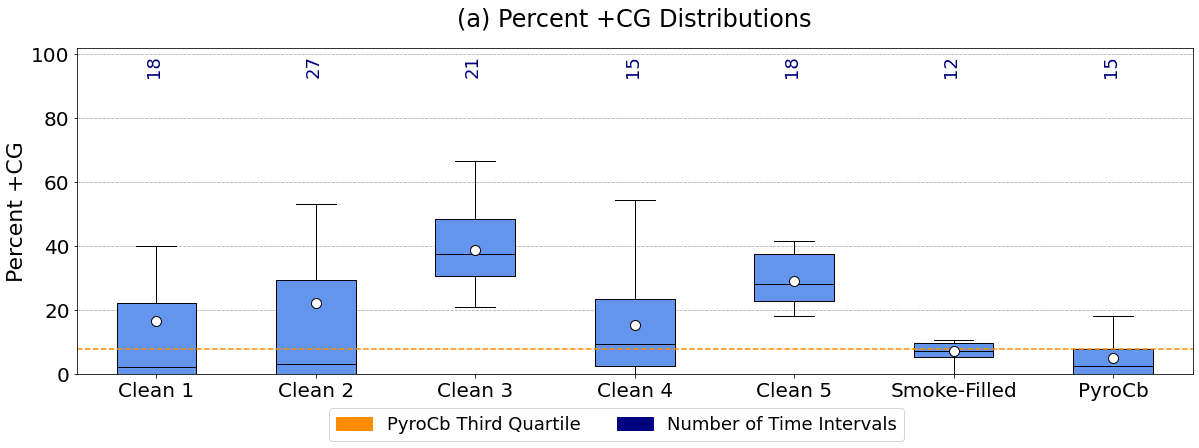

In [31]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Percent +CG", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
plt.ylim(0, 102)
data = [clean1perpos, clean2perpos, clean3perpos, clean4perpos, 
        clean5perpos, smokeperpos, pyrocbperpos]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

firstq = np.quantile(pyrocbperpos, 0.75)
plt.axhline(y=firstq,  linestyle='--', color = "darkorange")

x = np.arange(1, 8, 1)
for i in range(0, 7, 1):
    plt.annotate(len(data[i]), (x[i] - 0.07, 94), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
            bbox_to_anchor=(0.5, -0.05),
            ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(a) Percent +CG Distributions', fontsize = 24, y=1.05)

plt.savefig("figure8a.png",bbox_inches = "tight", dpi = 800)
plt.show()


In [32]:
# clean1perpos, clean2perpos, clean3perpos, clean4perpos, clean5perpos, smokeperpos, pyrocbperpos

t_statistic, p_value = ttest_ind(pyrocbperpos, smokeperpos)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = ttest_ind(pyrocbperpos, clean1perpos)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = ttest_ind(pyrocbperpos, clean2perpos)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = ttest_ind(pyrocbperpos, clean3perpos)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = ttest_ind(pyrocbperpos, clean4perpos)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = ttest_ind(pyrocbperpos, clean5perpos)
print("t-statistic:", t_statistic)
print("p-value:", p_value)


t-statistic: -0.9413080456911913
p-value: 0.3555545574010811
t-statistic: -1.6079717624602523
p-value: 0.11798015552053971
t-statistic: -2.065646761571991
p-value: 0.04538226289032495
t-statistic: -6.419651824883453
p-value: 2.468544826656359e-07
t-statistic: -2.2669544924873604
p-value: 0.031308993797369844
t-statistic: -9.183074124141685
p-value: 2.355526919200924e-10


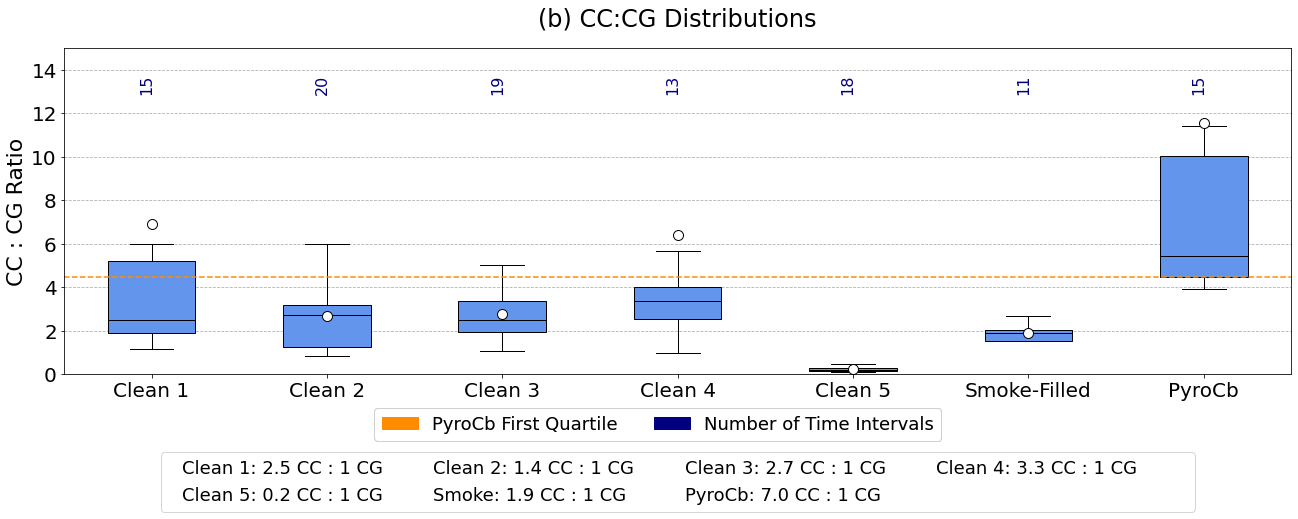

In [49]:
fig, ax = plt.subplots(figsize = (22,6))

ax.set_ylabel("CC : CG Ratio", color = "black", fontsize = 22)
plt.ylim(0, 15)
plt.yticks(fontsize = 20, color = "black")

data = [clean1_cccg_array, clean2_cccg_array, clean3_cccg_array, clean4_cccg_array, clean5_cccg_array, 
       smoke_cccg_array, pyrocb_cccg_array]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

firstq = np.quantile(pyrocb_cccg_array, 0.25)
plt.axhline(y=firstq,  linestyle='--', color = "darkorange")

x = np.arange(1, 8, 1)
for i in range(0, 7, 1):
    plt.annotate(len(data[i]), (x[i] - 0.07, 13), rotation=90, fontsize = 16, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb First Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
            bbox_to_anchor=(0.5, -0.05),
            ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

ax.add_artist(firstlegend)


clean1_patch = mpatches.Patch(color='white', label='Clean 1: {:.1f} CC : 1 CG'.format(len(clean1_cloud_flat) / (len(clean1_pos_ground_flat) + len(clean1_neg_ground_flat))))
clean2_patch = mpatches.Patch(color='white', label='Clean 2: {:.1f} CC : 1 CG'.format(len(clean2_cloud_flat) / (len(clean2_pos_ground_flat) + len(clean2_neg_ground_flat))))
clean3_patch = mpatches.Patch(color='white', label='Clean 3: {:.1f} CC : 1 CG'.format(len(clean3_cloud_flat) / (len(clean3_pos_ground_flat) + len(clean3_neg_ground_flat))))
clean4_patch = mpatches.Patch(color='white', label='Clean 4: {:.1f} CC : 1 CG'.format(len(clean4_cloud_flat) / (len(clean4_pos_ground_flat) + len(clean4_neg_ground_flat))))
clean5_patch = mpatches.Patch(color='white', label='Clean 5: {:.1f} CC : 1 CG'.format(len(clean5_cloud_flat) / (len(clean5_pos_ground_flat) + len(clean5_neg_ground_flat))))
# clean_patch = mpatches.Patch(color='white', label='Clean Composite: {:.1f} CC : 1 CG'.format(len(clean_cloud_flat) / (len(clean_pos_ground_flat) + len(clean_neg_ground_flat))))
smoke_patch = mpatches.Patch(color='white', label='Smoke: {:.1f} CC : 1 CG'.format(len(smoke_cloud_flat) / (len(smoke_pos_ground_flat) + len(smoke_neg_ground_flat))))
pyrocb_patch = mpatches.Patch(color='white', label='PyroCb: {:.1f} CC : 1 CG'.format(len(pyrocb_cloud_flat) / (len(pyrocb_pos_ground_flat) + len(pyrocb_neg_ground_flat))))
blank_patch = mpatches.Patch(color='white')

ax.legend(handles=[clean1_patch, clean5_patch, clean2_patch, smoke_patch, clean3_patch, pyrocb_patch, 
                   clean4_patch, blank_patch], fontsize = 18, loc='lower center', 
           bbox_to_anchor=(0.5, -0.45),
          ncol=5, fancybox=True, shadow=False, 
          handlelength=0, handleheight=1)

plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(b) CC:CG Distributions', fontsize = 24, y = 1.05)

plt.savefig("figure8b.png",bbox_inches = "tight", dpi = 800)
plt.show()


# BCC and percent positive correlations

In [42]:
# bcc mean and percent pos
bcc= np.array([np.mean(m_clean1_bc.BCCMASS), 
              np.mean(m_clean2_bc.BCCMASS), np.mean(m_clean3_bc.BCCMASS), np.mean(m_clean4_bc.BCCMASS),
              np.mean(m_clean5_bc.BCCMASS), np.mean(m_smoke_bc.BCCMASS), np.mean(m_pyrocb_bc.BCCMASS)])

pos = np.array([np.mean(clean1perpos), np.mean(clean2perpos), 
                np.mean(clean3perpos), np.mean(clean4perpos), np.mean(clean5perpos), 
                np.mean(smokeperpos),  np.mean(pyrocbperpos)])

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(bcc, pos)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.565180821440532
P-value: 0.18611056062790624


In [50]:
# bcc max and percent pos
bcc= np.array([np.mean(m_clean1_bc.BCCMASS), 
              np.mean(m_clean2_bc.BCCMASS), np.mean(m_clean3_bc.BCCMASS), np.mean(m_clean4_bc.BCCMASS),
              np.mean(m_clean5_bc.BCCMASS), np.mean(m_smoke_bc.BCCMASS), np.mean(m_pyrocb_bc.BCCMASS)])

pos = np.array([np.max(clean1perpos), np.max(clean2perpos), 
                np.max(clean3perpos), np.max(clean4perpos), np.max(clean5perpos), 
                np.max(smokeperpos),  np.max(pyrocbperpos)])

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(bcc, pos)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.6400166421516884
P-value: 0.12156972331229915


/tmp/ipykernel_375447/1905653724.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pos_arrays = np.array([d3["percent_pos_current_cloud_ground_clean1"],


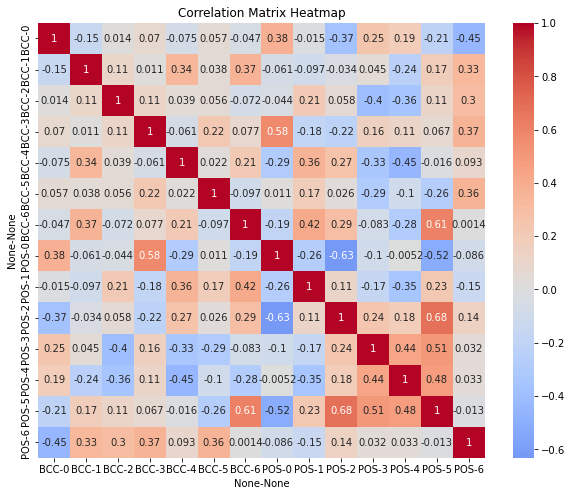

In [36]:
bcc_arrays = [m_clean1_bc.BCCMASS, m_clean2_bc.BCCMASS, m_clean3_bc.BCCMASS, m_clean4_bc.BCCMASS, m_clean5_bc.BCCMASS, 
                  m_smoke_bc.BCCMASS, m_pyrocb_bc.BCCMASS]
pos_arrays = np.array([d3["percent_pos_current_cloud_ground_clean1"], 
                d4["percent_pos_current_cloud_ground_clean2"], 
                d5["percent_pos_current_cloud_ground_clean3"], 
                d6["percent_pos_current_cloud_ground_clean4"], 
                d7["percent_pos_current_cloud_ground_clean5"], 
                d2["percent_pos_current_cloud_ground_smoke"],
                d1["percent_pos_current_cloud_ground_pyrocb"]])

# Step 3: Pad arrays with NaN to make them the same length
max_length = max(max(len(arr) for arr in bcc_arrays), max(len(arr) for arr in pos_arrays))

def pad_with_nan(arr, length):
    return np.pad(arr, (0, length - len(arr)), constant_values=np.nan)

padded_variable1 = [pad_with_nan(arr, max_length) for arr in bcc_arrays]
padded_variable2 = [pad_with_nan(arr, max_length) for arr in pos_arrays]

# Step 4: Convert to DataFrames
df1 = pd.DataFrame(padded_variable1).transpose()
df2 = pd.DataFrame(padded_variable2).transpose()

# Combine the two DataFrames into one, aligning by column
combined_df = pd.concat([df1, df2], axis=1, keys=['BCC', 'POS'])

# Step 5: Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

[0.37610509897023636, -0.09740231461265705, 0.05842644595756698, 0.1580573259038392, -0.4500864393307041, -0.2624249411498823, 0.0013913443993421777]


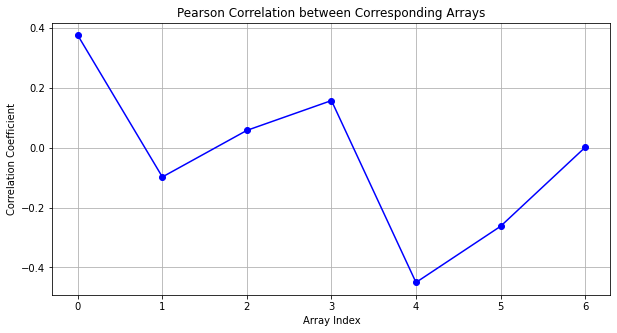

In [37]:
correlations = []

for arr1, arr2 in zip(bcc_arrays, pos_arrays):
    # Ensure both arrays have the same length for correlation calculation
    min_length = min(len(arr1), len(arr2))
    arr1_trimmed = arr1[:min_length]
    arr2_trimmed = arr2[:min_length]

    # Compute Pearson correlation coefficient
    if len(arr1_trimmed) > 1:  # Need at least 2 data points to compute correlation
        correlation, _ = pearsonr(arr1_trimmed, arr2_trimmed)
        correlations.append(correlation)
    else:
        correlations.append(np.nan)  # Correlation is not defined for single data point

print(correlations)

# Plot correlations
plt.figure(figsize=(10, 5))
plt.plot(correlations, marker='o', linestyle='-', color='b')
plt.title('Pearson Correlation between Corresponding Arrays')
plt.xlabel('Array Index')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

## BCC and peak current
- want to see any correlation between smoke levels and peak current?

In [54]:
# bcc mean and pos CG current 
bcc= np.array([np.mean(m_clean1_bc.BCCMASS), 
              np.mean(m_clean2_bc.BCCMASS), np.mean(m_clean3_bc.BCCMASS), np.mean(m_clean4_bc.BCCMASS),
              np.mean(m_clean5_bc.BCCMASS), np.mean(m_smoke_bc.BCCMASS), np.mean(m_pyrocb_bc.BCCMASS)])

pos_current = np.array([np.max(clean1_pos_ground_flat), np.max(clean2_pos_ground_flat), 
                np.max(clean3_pos_ground_flat), np.max(clean4_pos_ground_flat), np.max(clean5_pos_ground_flat), 
                np.max(smoke_pos_ground_flat),  np.max(pyrocb_pos_ground_flat)])

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(bcc, pos_current)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.8506309985326559
P-value: 0.015255897885039142


In [53]:
# bcc mean and neg CG current
bcc= np.array([np.mean(m_clean1_bc.BCCMASS), 
              np.mean(m_clean2_bc.BCCMASS), np.mean(m_clean3_bc.BCCMASS), np.mean(m_clean4_bc.BCCMASS),
              np.mean(m_clean5_bc.BCCMASS), np.mean(m_smoke_bc.BCCMASS), np.mean(m_pyrocb_bc.BCCMASS)])

neg_current = np.array([np.min(clean1_neg_ground_flat), np.min(clean2_neg_ground_flat), 
                np.min(clean3_neg_ground_flat), np.min(clean4_neg_ground_flat), np.min(clean5_neg_ground_flat), 
                np.min(smoke_neg_ground_flat),  np.min(pyrocb_neg_ground_flat)])

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(bcc, neg_current)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.729659269205496
P-value: 0.06269793426866739
